# Loan Default

## Detail Analysis:

## Data Loading and Understanding

In [1]:
import sys
import xgboost
print("Python version:", sys.version)
print("XGboost version:", xgboost.__version__)

Python version: 3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
XGboost version: 0.90


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint,EarlyStopping

Using TensorFlow backend.


In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
raw_df = pd.read_csv('raw-data.csv')
raw_df.head()

,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,mo_sin_earliest_cr_line,label,percent_bc_sats,percent_bc_open_to_buy,percent_sats,percent_rev_tl_bal_gt_0,percent_tot_cur_bal_of_hi_cred_lim
0,40425321,13.66,260.20,120,1,50000.0,Dec 2014,34.81,0,1,...,64426,4900,64031,148.0,1,0.250000,0.067755,1.0,1.0,0.782524
1,40375473,17.14,319.08,180,10,125000.0,Dec 2014,8.31,1,0,...,18007,4400,18000,170.0,0,0.600000,0.000000,1.0,1.0,0.710103
2,39557379,14.31,800.71,130,10,72000.0,Dec 2014,27.03,1,0,...,79490,36000,78126,194.0,1,0.777778,0.110472,1.0,1.0,0.886614
3,40563521,17.86,468.17,190,10,60000.0,2014-12,22.42,0,0,...,17281,5500,27243,191.0,1,0.500000,0.473455,1.0,1.0,0.402417
4,40485257,21.99,581.95,240,10,55000.0,Dec 2014,29.50,0,0,...,62443,16300,55441,325.0,0,0.500000,0.090061,1.0,1.0,0.873350


In [6]:
raw_df.shape

(1038963, 64)

In [7]:
raw_df.tail(10)

,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,mo_sin_earliest_cr_line,label,percent_bc_sats,percent_bc_open_to_buy,percent_sats,percent_rev_tl_bal_gt_0,percent_tot_cur_bal_of_hi_cred_lim
1038953,68480216,18.49,769.83,210,5,194000.0,Nov 2015,16.06,1,0,...,82579,20300,84436,156.0,1,1.000000,0.184975,1.000000,1.000000,0.838392
1038954,17372624,20.20,417.38,220,10,84000.0,2014-05,24.77,0,4,...,79407,3500,73647,192.0,0,0.200000,0.134571,1.000000,1.000000,0.914702
1038955,41432127,15.59,699.10,150,10,59000.0,Jan 2015,21.81,0,0,...,51252,13600,37271,153.0,0,0.750000,0.118162,1.000000,1.000000,0.840596
1038956,60797000,9.17,350.67,60,5,65000.0,Aug 2015,15.82,0,0,...,36619,7800,46231,159.0,0,0.750000,0.147564,1.000000,1.000000,0.665425
1038957,56158570,10.99,217.38,80,2,33500.0,Jul 2015,27.52,0,0,...,38024,19300,20061,142.0,0,1.000000,0.351710,1.000000,1.090909,0.738890
1038958,64536886,7.89,782.15,40,2,70000.0,Oct 2015,38.45,1,0,...,85635,80760,21155,512.0,0,1.000000,0.166667,0.923077,0.666667,0.835883
1038959,34401155,9.17,318.79,50,3,33000.0,2014-10,11.56,1,1,...,8878,7000,4000,125.0,0,1.000000,0.040714,1.000000,1.000000,0.916974
1038960,15319045,12.99,943.30,90,10,95000.0,Apr 2014,5.95,0,2,...,15755,21000,0,151.0,0,0.571429,0.399809,1.000000,1.000000,0.963166
1038961,64783452,5.32,191.23,0,2,74000.0,2015-10,12.20,0,0,...,119807,24200,123088,147.0,0,0.600000,0.828223,1.000000,1.000000,0.888489
1038962,13689270,10.99,392.81,60,1,40000.0,2014-03,23.76,0,1,...,91076,20700,88546,125.0,0,0.714286,0.337295,1.000000,1.000000,0.811396


It appears the devices are different types. The same type has the same first 4 letters.

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038963 entries, 0 to 1038962
Data columns (total 64 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   member_id                           1038963 non-null  int64  
 1   int_rate                            1038963 non-null  float64
 2   installment                         1038963 non-null  float64
 3   sub_grade                           1038963 non-null  int64  
 4   emp_length                          1038963 non-null  int64  
 5   annual_inc                          1038963 non-null  float64
 6   issue_d                             1038963 non-null  object 
 7   dti                                 1038963 non-null  float64
 8   delinq_2yrs                         1038963 non-null  int64  
 9   inq_last_6mths                      1038963 non-null  int64  
 10  mths_since_last_delinq              1038963 non-null  int64  
 11  mths_since_

In [9]:
raw_df.describe()

,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,mo_sin_earliest_cr_line,label,percent_bc_sats,percent_bc_open_to_buy,percent_sats,percent_rev_tl_bal_gt_0,percent_tot_cur_bal_of_hi_cred_lim
count,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,...,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06,1.038963e+06
mean,4.892405e+07,1.290128e+01,4.419571e+02,1.099976e+02,5.724132e+00,7.562500e+04,1.926272e+01,3.516516e-01,5.925543e-01,2.452299e+03,...,5.129641e+04,2.159076e+04,4.231164e+04,1.995709e+02,1.177318e-01,6.357632e-01,3.548103e-01,9.956570e-01,9.964302e-01,7.305560e-01
std,1.780281e+07,4.357063e+00,2.414444e+02,6.465604e+01,3.848734e+00,6.968433e+04,2.549743e+01,9.236110e-01,8.949173e-01,2.482456e+03,...,4.841355e+04,2.149048e+04,4.329516e+04,1.001038e+02,3.222905e-01,2.498767e-01,2.667140e-01,2.453107e-02,8.769988e-02,1.894765e-01
min,7.082500e+04,5.320000e+00,2.336000e+01,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,-6.570000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.710726e+07,9.170000e+00,2.668400e+02,6.000000e+01,2.000000e+00,4.500000e+04,1.275000e+01,0.000000e+00,0.000000e+00,2.900000e+01,...,2.217800e+04,7.700000e+03,1.492300e+04,1.390000e+02,0.000000e+00,4.500000e-01,1.244928e-01,1.000000e+00,1.000000e+00,6.174038e-01
50%,5.194283e+07,1.269000e+01,3.858600e+02,1.000000e+02,6.000000e+00,6.500000e+04,1.872000e+01,0.000000e+00,0.000000e+00,7.800000e+01,...,3.886100e+04,1.500000e+04,3.184300e+04,1.840000e+02,0.000000e+00,6.363636e-01,3.123881e-01,1.000000e+00,1.000000e+00,7.730846e-01
75%,6.458728e+07,1.561000e+01,5.777900e+02,1.500000e+02,1.000000e+01,9.000000e+04,2.533000e+01,0.000000e+00,1.000000e+00,5.000000e+03,...,6.435500e+04,2.820000e+04,5.676000e+04,2.490000e+02,0.000000e+00,8.333333e-01,5.453226e-01,1.000000e+00,1.000000e+00,8.729831e-01
max,7.354484e+07,2.899000e+01,1.445460e+03,3.400000e+02,1.000000e+01,9.500000e+06,9.999000e+03,3.000000e+01,6.000000e+00,5.000000e+03,...,2.921551e+06,1.090700e+06,1.269783e+06,5.630000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01,9.019243e+00


In [10]:
print(raw_df['label'].value_counts())

0    916644
1    122319
Name: label, dtype: int64


The data shows 124494*0.000851 = 106 failures out of 124494 records. This shows a small fraction of failures. 

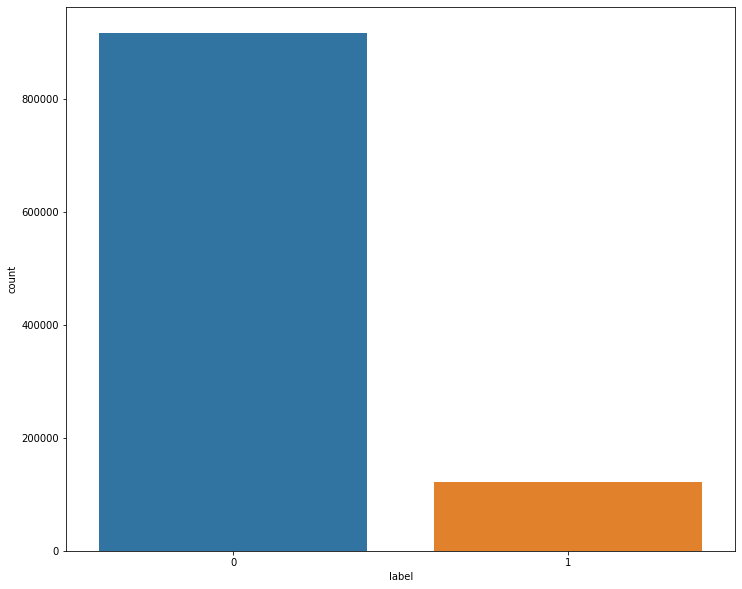

In [11]:
sns.countplot(raw_df['label'],label="Count")

It shows its an imbalanced dataset.

In [12]:
corr = raw_df.corr(method='pearson')
# method="pearson","spearman",or "kendall"
corr

,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,mo_sin_earliest_cr_line,label,percent_bc_sats,percent_bc_open_to_buy,percent_sats,percent_rev_tl_bal_gt_0,percent_tot_cur_bal_of_hi_cred_lim
member_id,1.000000,-0.171429,-0.015195,-0.092800,-0.017488,0.022782,0.016105,-0.002245,-8.059254e-02,-0.006816,...,0.038989,0.045453,0.045260,0.004990,-0.138126,0.074869,0.059057,-0.006688,0.021070,-0.031116
int_rate,-0.171429,1.000000,0.105469,0.992200,-0.006778,-0.094291,0.065258,0.045063,2.309178e-01,-0.055809,...,-0.015327,-0.258872,-0.012134,-0.116513,0.247045,0.040153,-0.242008,-0.013293,-0.021117,0.140964
installment,-0.015195,0.105469,1.000000,0.106753,0.107399,0.313912,0.002198,-0.000014,-5.466028e-03,0.011323,...,0.267281,0.364509,0.180995,0.143133,0.023490,-0.014495,-0.066488,0.027649,0.005791,0.096070
sub_grade,-0.092800,0.992200,0.106753,1.000000,-0.007911,-0.092836,0.067599,0.045010,2.254812e-01,-0.056684,...,-0.010657,-0.256740,-0.007460,-0.117199,0.239050,0.046228,-0.240333,-0.013151,-0.019987,0.140843
emp_length,-0.017488,-0.006778,0.107399,-0.007911,1.000000,0.092600,0.001320,0.025389,-4.468599e-03,-0.041632,...,0.021426,0.077120,0.002044,0.122246,-0.030283,-0.053701,-0.026019,-0.004861,0.000407,0.035789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
percent_bc_sats,0.074869,0.040153,-0.014495,0.046228,-0.053701,-0.031236,0.005352,-0.109339,-1.018479e-07,0.212966,...,-0.008642,0.100582,-0.033171,-0.178252,-0.010311,1.000000,0.024588,0.041753,-0.053699,-0.029477
percent_bc_open_to_buy,0.059057,-0.242008,-0.066488,-0.240333,-0.026019,-0.003988,-0.055436,0.014517,6.313716e-02,-0.011625,...,-0.080217,0.232301,-0.020679,0.007992,-0.027826,0.024588,1.000000,-0.011701,-0.007612,-0.357805
percent_sats,-0.006688,-0.013293,0.027649,-0.013151,-0.004861,0.001850,0.003037,-0.061887,-6.616676e-02,0.034587,...,0.021443,0.041185,0.018173,-0.066841,0.000523,0.041753,-0.011701,1.000000,0.156143,0.025650
percent_rev_tl_bal_gt_0,0.021070,-0.021117,0.005791,-0.019987,0.000407,0.001477,0.004742,-0.011562,-8.618669e-02,-0.014426,...,0.023841,0.007781,0.013559,-0.017169,-0.011081,-0.053699,-0.007612,0.156143,1.000000,0.018724


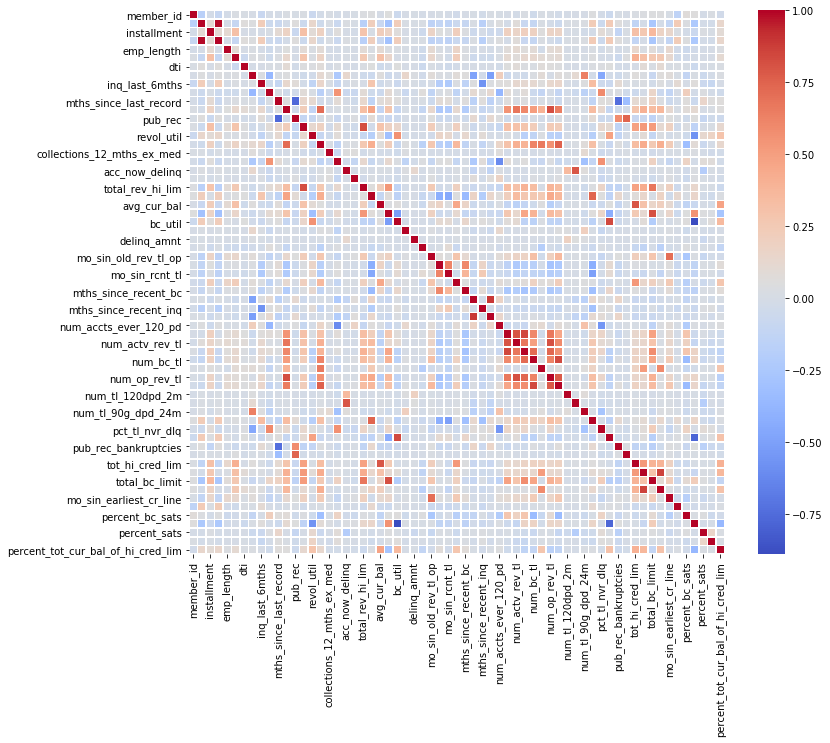

In [13]:
sns.heatmap(corr,    
            cmap='coolwarm',
            linewidths=.5, 
           )

It shows metric7 and metric8 are the same. One of them can be dropped. Metric3 and metric9 are highled related. 

In [14]:
raw_df.isnull().sum()

member_id                             0
int_rate                              0
installment                           0
sub_grade                             0
emp_length                            0
                                     ..
percent_bc_sats                       0
percent_bc_open_to_buy                0
percent_sats                          0
percent_rev_tl_bal_gt_0               0
percent_tot_cur_bal_of_hi_cred_lim    0
Length: 64, dtype: int64

In [18]:
raw_df=raw_df.fillna(raw_df.mean())

In [19]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038963 entries, 0 to 1038962
Data columns (total 64 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   member_id                           1038963 non-null  int64  
 1   int_rate                            1038963 non-null  float64
 2   installment                         1038963 non-null  float64
 3   sub_grade                           1038963 non-null  int64  
 4   emp_length                          1038963 non-null  int64  
 5   annual_inc                          1038963 non-null  float64
 6   issue_d                             1038963 non-null  object 
 7   dti                                 1038963 non-null  float64
 8   delinq_2yrs                         1038963 non-null  int64  
 9   inq_last_6mths                      1038963 non-null  int64  
 10  mths_since_last_delinq              1038963 non-null  int64  
 11  mths_since_

In [20]:
raw_df.to_csv("non_null_data.csv")

In [4]:
raw_df = pd.read_csv('non_null_data.csv')

New feature

In [179]:
# raw_df['install_inc']=raw_df['installment']/(raw_df['annual_inc']/12+10)


In [5]:
raw_df.issue_d = pd.to_datetime(raw_df.issue_d,infer_datetime_format=True)

In [6]:
raw_df.head()

,Unnamed: 0,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,mo_sin_earliest_cr_line,label,percent_bc_sats,percent_bc_open_to_buy,percent_sats,percent_rev_tl_bal_gt_0,percent_tot_cur_bal_of_hi_cred_lim
0,0,40425321,13.66,260.20,120,1,50000.0,2014-12-01,34.81,0,...,64426,4900,64031,148.0,1,0.250000,0.067755,1.0,1.0,0.782524
1,1,40375473,17.14,319.08,180,10,125000.0,2014-12-01,8.31,1,...,18007,4400,18000,170.0,0,0.600000,0.000000,1.0,1.0,0.710103
2,2,39557379,14.31,800.71,130,10,72000.0,2014-12-01,27.03,1,...,79490,36000,78126,194.0,1,0.777778,0.110472,1.0,1.0,0.886614
3,3,40563521,17.86,468.17,190,10,60000.0,2014-12-01,22.42,0,...,17281,5500,27243,191.0,1,0.500000,0.473455,1.0,1.0,0.402417
4,4,40485257,21.99,581.95,240,10,55000.0,2014-12-01,29.50,0,...,62443,16300,55441,325.0,0,0.500000,0.090061,1.0,1.0,0.873350


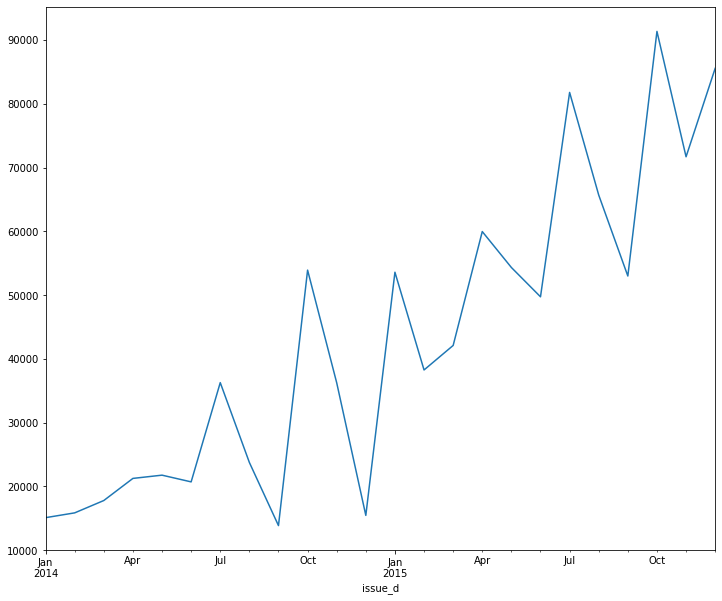

In [7]:
raw_df.groupby('issue_d')['label'].count().plot()

default increases with time.

In [8]:
# create time features based on date.


raw_df['activedays']=raw_df.issue_d-raw_df.issue_d[0]

raw_df['month']=raw_df['issue_d'].dt.month
#raw_df['week_day']=raw_df.issue_d.dt.weekday
#raw_df['week_day'].replace(0,7,inplace=True)


In [9]:
raw_df.activedays = raw_df.activedays.astype('str')
raw_df.activedays = raw_df.activedays.apply(lambda x: x.split(' ')[0])
raw_df.activedays = raw_df.activedays.astype('int')
raw_df.activedays = raw_df.activedays.apply(lambda x: x+1)

raw_df.head()
# first day is changed to day 1

,Unnamed: 0,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,...,total_il_high_credit_limit,mo_sin_earliest_cr_line,label,percent_bc_sats,percent_bc_open_to_buy,percent_sats,percent_rev_tl_bal_gt_0,percent_tot_cur_bal_of_hi_cred_lim,activedays,month
0,0,40425321,13.66,260.20,120,1,50000.0,2014-12-01,34.81,0,...,64031,148.0,1,0.250000,0.067755,1.0,1.0,0.782524,1,12
1,1,40375473,17.14,319.08,180,10,125000.0,2014-12-01,8.31,1,...,18000,170.0,0,0.600000,0.000000,1.0,1.0,0.710103,1,12
2,2,39557379,14.31,800.71,130,10,72000.0,2014-12-01,27.03,1,...,78126,194.0,1,0.777778,0.110472,1.0,1.0,0.886614,1,12
3,3,40563521,17.86,468.17,190,10,60000.0,2014-12-01,22.42,0,...,27243,191.0,1,0.500000,0.473455,1.0,1.0,0.402417,1,12
4,4,40485257,21.99,581.95,240,10,55000.0,2014-12-01,29.50,0,...,55441,325.0,0,0.500000,0.090061,1.0,1.0,0.873350,1,12


In [10]:
raw_df.month = raw_df.month.astype('object')

In [11]:
raw_df = pd.get_dummies(raw_df,drop_first=True)

In [12]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038963 entries, 0 to 1038962
Data columns (total 77 columns):
 #   Column                              Non-Null Count    Dtype         
---  ------                              --------------    -----         
 0   Unnamed: 0                          1038963 non-null  int64         
 1   member_id                           1038963 non-null  int64         
 2   int_rate                            1038963 non-null  float64       
 3   installment                         1038963 non-null  float64       
 4   sub_grade                           1038963 non-null  int64         
 5   emp_length                          1038963 non-null  int64         
 6   annual_inc                          1038963 non-null  float64       
 7   issue_d                             1038963 non-null  datetime64[ns]
 8   dti                                 1038963 non-null  float64       
 9   delinq_2yrs                         1038963 non-null  int64         

In [13]:
raw_df.head()

,Unnamed: 0,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,40425321,13.66,260.20,120,1,50000.0,2014-12-01,34.81,0,...,0,0,0,0,0,0,0,0,0,1
1,1,40375473,17.14,319.08,180,10,125000.0,2014-12-01,8.31,1,...,0,0,0,0,0,0,0,0,0,1
2,2,39557379,14.31,800.71,130,10,72000.0,2014-12-01,27.03,1,...,0,0,0,0,0,0,0,0,0,1
3,3,40563521,17.86,468.17,190,10,60000.0,2014-12-01,22.42,0,...,0,0,0,0,0,0,0,0,0,1
4,4,40485257,21.99,581.95,240,10,55000.0,2014-12-01,29.50,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
raw_df=raw_df.iloc[:, 1:]
raw_df.head()

,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,40425321,13.66,260.20,120,1,50000.0,2014-12-01,34.81,0,1,...,0,0,0,0,0,0,0,0,0,1
1,40375473,17.14,319.08,180,10,125000.0,2014-12-01,8.31,1,0,...,0,0,0,0,0,0,0,0,0,1
2,39557379,14.31,800.71,130,10,72000.0,2014-12-01,27.03,1,0,...,0,0,0,0,0,0,0,0,0,1
3,40563521,17.86,468.17,190,10,60000.0,2014-12-01,22.42,0,0,...,0,0,0,0,0,0,0,0,0,1
4,40485257,21.99,581.95,240,10,55000.0,2014-12-01,29.50,0,0,...,0,0,0,0,0,0,0,0,0,1


The above shows the ratios of zero every column.

In [17]:
drop_col=['member_id',
          'issue_d',
          'label',
          'sub_grade',
          'mths_since_last_delinq',
          'mths_since_last_record',
          'total_acc',
          'mths_since_last_major_derog',
          'total_rev_hi_lim',
          'bc_open_to_buy',
          'mo_sin_old_rev_tl_op',
          'mo_sin_rcnt_rev_tl_op',
          'mo_sin_rcnt_tl',
          'mths_since_recent_bc',
          'mths_since_recent_bc_dlq',
          'mths_since_recent_inq',
          'mths_since_recent_revol_delinq',
          'num_actv_rev_tl',
          'num_bc_sats',
          'num_bc_tl',
          'num_il_tl',
          'num_op_rev_tl',
          'num_rev_accts',
          'num_tl_30dpd',
          'num_tl_90g_dpd_24m',
          'num_tl_op_past_12m',
          'pct_tl_nvr_dlq',
          'percent_bc_gt_75',
          'tax_liens',
          'tot_hi_cred_lim',
          'total_bc_limit',
          'total_il_high_credit_limit',
          'percent_bc_sats',
          'percent_bc_open_to_buy',
          'percent_sats'
         ]

In [18]:
X=raw_df.drop(drop_col, axis=1)
y=raw_df['label']

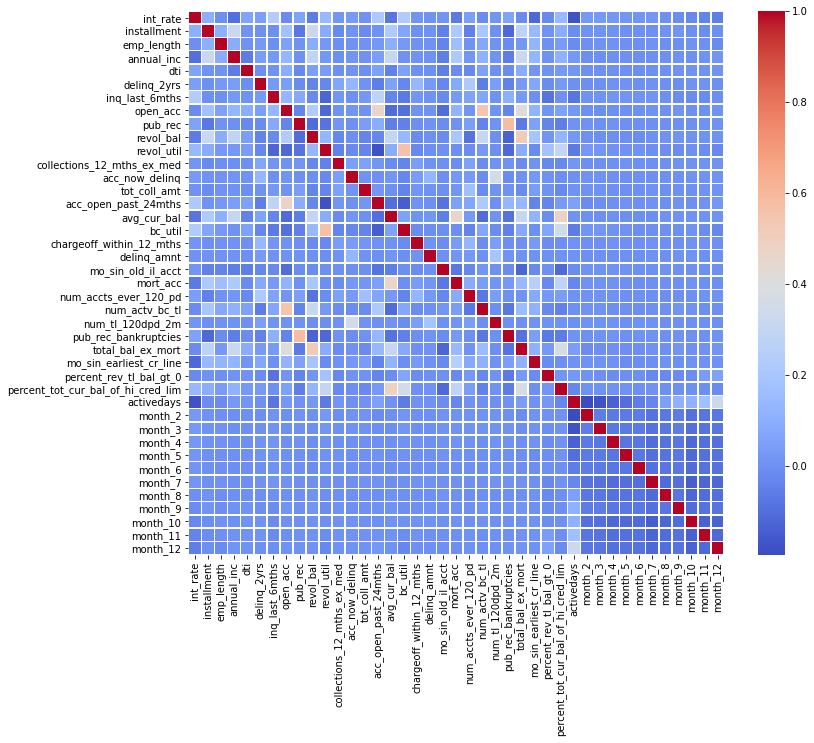

In [19]:
corr = X.corr(method='pearson')
# method="pearson","spearman",or "kendall"

sns.heatmap(corr,    
            cmap='coolwarm',
            linewidths=.5, 
           )

In [20]:
X.head()

,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,13.66,260.20,1,50000.0,34.81,0,1,11,0,16822,...,0,0,0,0,0,0,0,0,0,1
1,17.14,319.08,10,125000.0,8.31,1,0,8,0,5753,...,0,0,0,0,0,0,0,0,0,1
2,14.31,800.71,10,72000.0,27.03,1,0,14,0,32372,...,0,0,0,0,0,0,0,0,0,1
3,17.86,468.17,10,60000.0,22.42,0,0,11,0,5200,...,0,0,0,0,0,0,0,0,0,1
4,21.99,581.95,10,55000.0,29.50,0,0,14,0,15955,...,0,0,0,0,0,0,0,0,0,1


# New features

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038963 entries, 0 to 1038962
Data columns (total 41 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   int_rate                            1038963 non-null  float64
 1   installment                         1038963 non-null  float64
 2   emp_length                          1038963 non-null  int64  
 3   annual_inc                          1038963 non-null  float64
 4   dti                                 1038963 non-null  float64
 5   delinq_2yrs                         1038963 non-null  int64  
 6   inq_last_6mths                      1038963 non-null  int64  
 7   open_acc                            1038963 non-null  int64  
 8   pub_rec                             1038963 non-null  int64  
 9   revol_bal                           1038963 non-null  int64  
 10  revol_util                          1038963 non-null  float64
 11  collections

In [22]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=42)

In [23]:
Xtrain.shape

(519481, 41)

In [24]:
X=Xtrain
y=ytrain

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519481 entries, 97910 to 121958
Data columns (total 41 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   int_rate                            519481 non-null  float64
 1   installment                         519481 non-null  float64
 2   emp_length                          519481 non-null  int64  
 3   annual_inc                          519481 non-null  float64
 4   dti                                 519481 non-null  float64
 5   delinq_2yrs                         519481 non-null  int64  
 6   inq_last_6mths                      519481 non-null  int64  
 7   open_acc                            519481 non-null  int64  
 8   pub_rec                             519481 non-null  int64  
 9   revol_bal                           519481 non-null  int64  
 10  revol_util                          519481 non-null  float64
 11  collections_12_mths_ex

In [26]:
scaler = StandardScaler()
X.iloc[:,0:30]=scaler.fit_transform(X.iloc[:,0:30])
print(X.shape,y.shape)

(519481, 41) (519481,)


In [27]:
X = np.clip(X, -5, 5)


In [28]:
X.head()

,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
97910,1.071405,0.231584,-1.227253,-0.319029,0.201380,-0.381828,1.574402,-0.159976,1.186566,-0.012876,...,0,1,0,0,0,0,0,0,0,0
560907,2.121840,-0.110222,0.071805,0.069404,0.568369,2.865505,-0.661767,-0.339703,-0.346962,-0.364137,...,0,0,0,1,0,0,0,0,0,0
641270,0.098951,-0.881314,0.851239,-0.707461,0.412154,0.700616,-0.661767,0.019752,-0.346962,-0.030666,...,0,0,0,0,0,0,0,0,0,0
997686,-0.313884,-1.007360,1.111051,-0.396715,0.542072,0.700616,-0.661767,0.199479,-0.346962,0.568676,...,0,0,0,0,0,0,0,0,1,0
796201,-0.139576,0.240398,-0.707630,0.535522,0.306963,-0.381828,-0.661767,-0.878885,-0.346962,0.907146,...,0,0,0,0,1,0,0,0,0,0


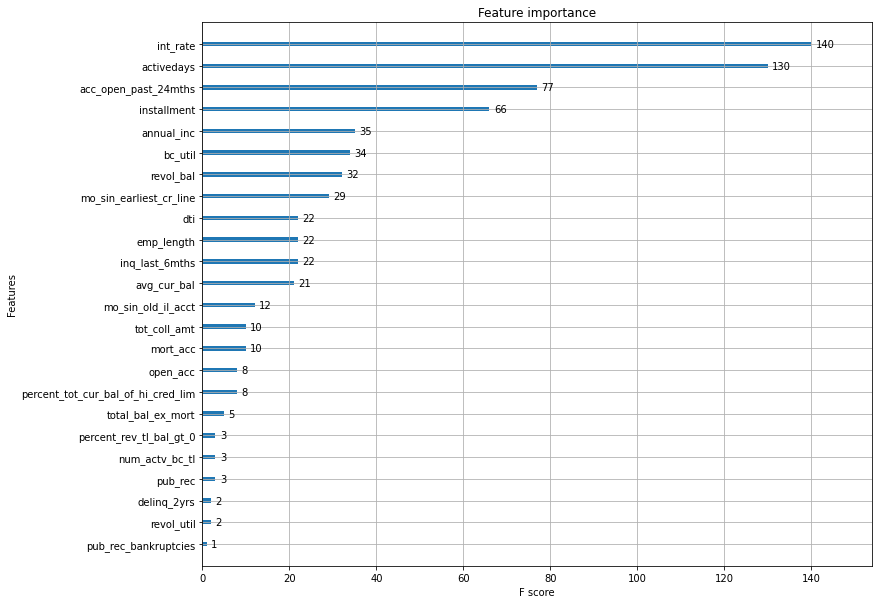

In [29]:
xgb_model = XGBClassifier() 
'''
xgb_model =  XGBClassifier(colsample_bytree=0.6,
 gamma=0.6,
 learning_rate=0.4,
 max_depth=6,
 n_estimators=60,
 min_child_weight=1,
 subsample=0.85)  
'''


xgb_model.fit(X, y)
plot_importance(xgb_model, max_num_features=40) # top 40 most important features
plt.show()

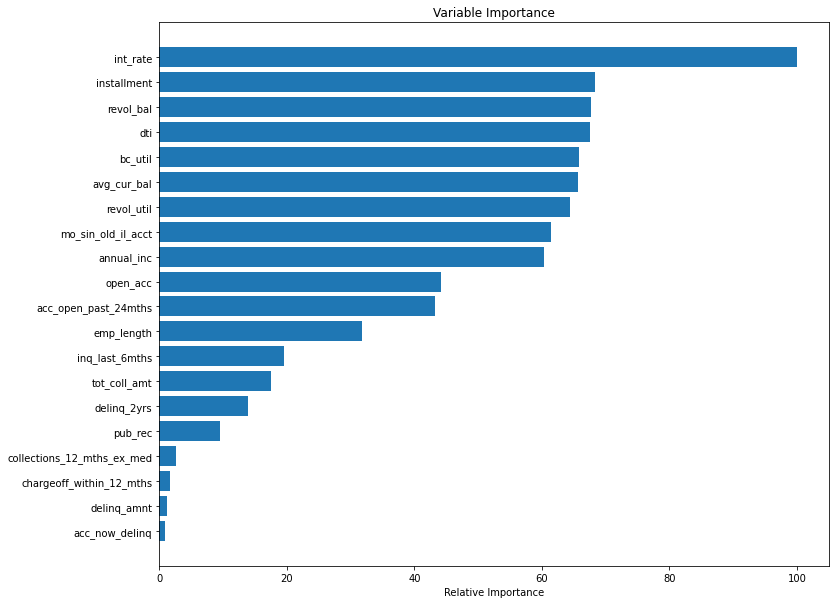

<Figure size 1440x720 with 0 Axes>

In [30]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X, y)

# Plot feature importance
feature_importance = rfc_model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance[0:20]) #first 20 important features
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(20,10))
plt.show()


In [31]:
model = SelectFromModel(xgb_model,prefit=True)
X_selected = model.transform(X)
X_selected[:]=pd.DataFrame(X_selected[:])
print(X_selected.shape)

(519481, 10)


In [32]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from collections import Counter
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')


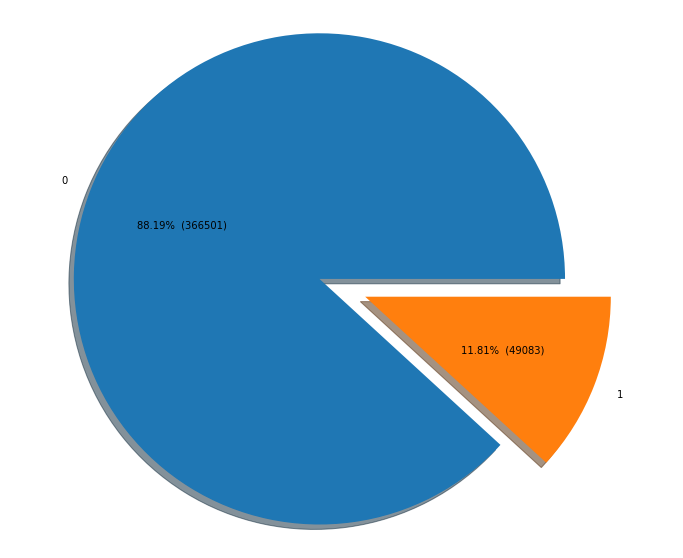

In [34]:
plot_pie(original_ytrain)

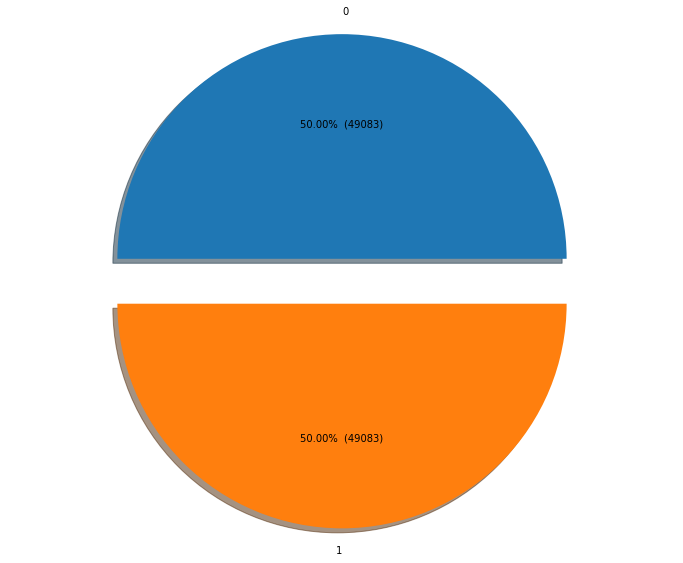

In [35]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = 1

rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
rus.fit(original_Xtrain, original_ytrain)
X_resampled, y_resampled = rus.fit_resample(original_Xtrain, original_ytrain)
plot_pie(y_resampled)

## Feature engineering

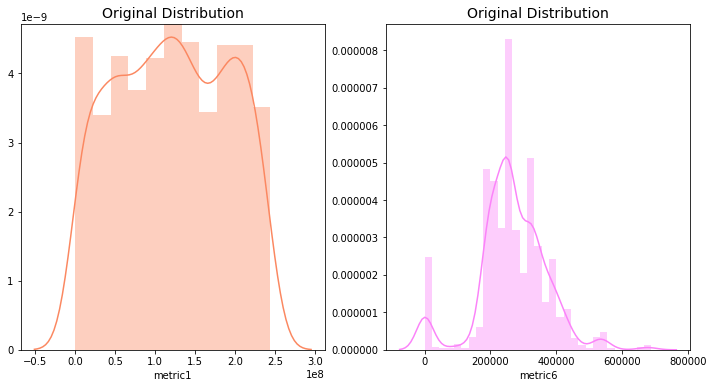

In [47]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

sns.distplot(df2['metric1'],ax=ax1, color='#FB8861')
ax1.set_title('Original Distribution', fontsize=14)

sns.distplot(df2['metric6'],ax=ax2, color='#FB83F9')
ax2.set_title('Original Distribution', fontsize=14)

plt.show()

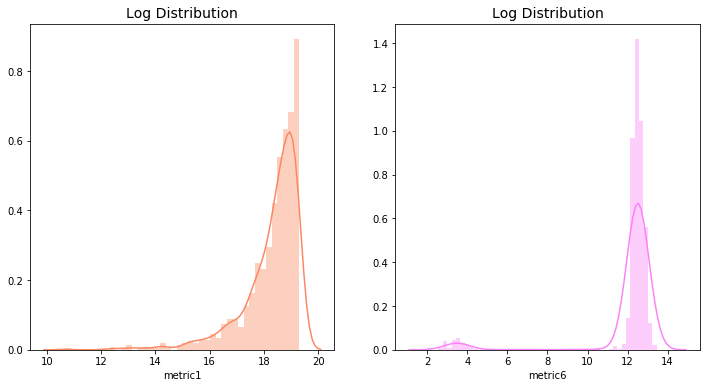

In [48]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

sns.distplot(np.log(1+df2['metric1']),ax=ax1, color='#FB8861')
ax1.set_title('Log Distribution', fontsize=14)

sns.distplot(np.log(1+df2['metric6']),ax=ax2, color='#FB83F9')
ax2.set_title('Log Distribution', fontsize=14)

plt.show()

In [49]:
new_df2=new_df1.copy()
for i in num_cols:
    new_df2[i]=np.log(1+new_df2[i])

Both removing outlier and log transformed data were studied. However, they did not give better results. They are not used in the final model.

## Modeling and evaluation

Ensemble learning (bagging or boosting) methods are generaly good at imbalanced data. Other methods are also studied for comparison purpose.
Confusion matrix, recall, precision and F1 score are the main metrics that are used to evaluate the models. 

### Confusion matrix plot

In [37]:
def plot_confusion_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions>p)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-default Detected (True Negatives): ', cm[0][0])
  print('Non-default Incorrectly Detected (False Positives): ', cm[0][1])
  print('Default Missed (False Negatives): ', cm[1][0])
  print('Default Detected (True Positives): ', cm[1][1])
  print('Total Default: ', np.sum(cm[1]))

In [38]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,10])
  plt.ylim([40,100.5])
  plt.grid(True)
  ax = plt.gca()

Define metrics list

In [39]:
mod_name=[]   #save model name
Acc = []      #save accuracy
F1 = []       #save f1 score      
Reca= []      #save recall
Preci = []    #save precision
Aucs=[]

In [40]:
def predictor(X, y, mtd):
    y_prediction = mtd.predict(X)

    #Compute error between predicted data and true response and display it in confusion matrix
    f1score = metrics.f1_score(y, y_prediction)
    accu=metrics.accuracy_score(y, y_prediction)
    rec=metrics.recall_score(y, y_prediction)
    prec=metrics.precision_score(y, y_prediction)
    auc=metrics.roc_auc_score(y, y_prediction)
    plot_confusion_matrix(y, y_prediction)
    print("f1_score:",f1score)  
    Acc.append(accu) 
    F1.append(f1score) 
    Reca.append(rec) 
    Preci.append(prec)
    Aucs.append(auc)

### Logistic regression

Non-default Detected (True Negatives):  62544
Non-default Incorrectly Detected (False Positives):  29195
Default Missed (False Negatives):  3858
Default Detected (True Positives):  8300
Total Default:  12158
f1_score: 0.3343201820635209


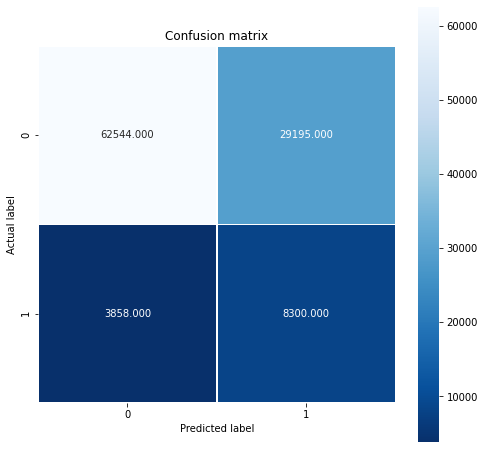

In [41]:
#Create and train model on train data sample
lg = LogisticRegression()
lg.fit(X_resampled, y_resampled)

#Predict for test data sample
predictor(original_Xtest, original_ytest, lg)
mod_name.append('Logistic Regression')

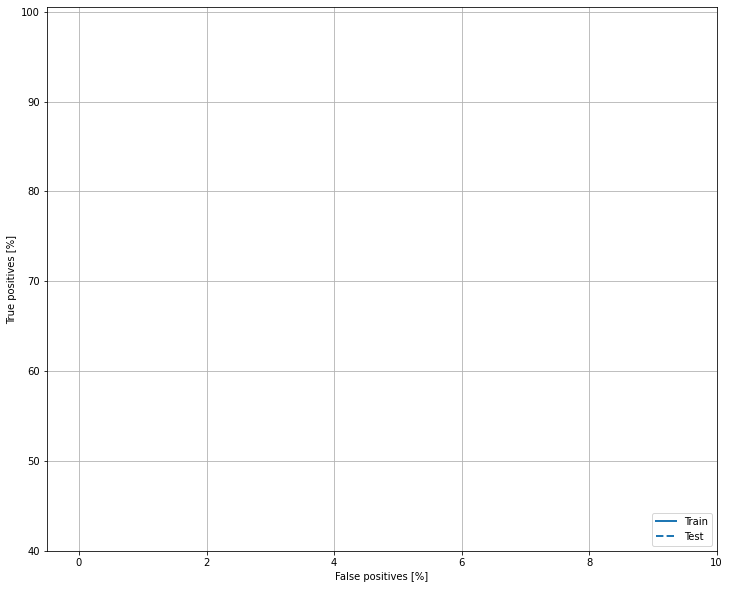

In [214]:
plot_roc("Train", y_resampled, lg.predict(X_resampled), color=colors[0])
plot_roc("Test", original_ytest,lg.predict(original_Xtest),linestyle='--')
plt.legend(loc='lower right')

### SVM

Non-default Detected (True Negatives):  8839
Non-default Incorrectly Detected (False Positives):  4865
Default Missed (False Negatives):  543
Default Detected (True Positives):  1338
Total Default:  1881
f1_score: 0.33102424542305786


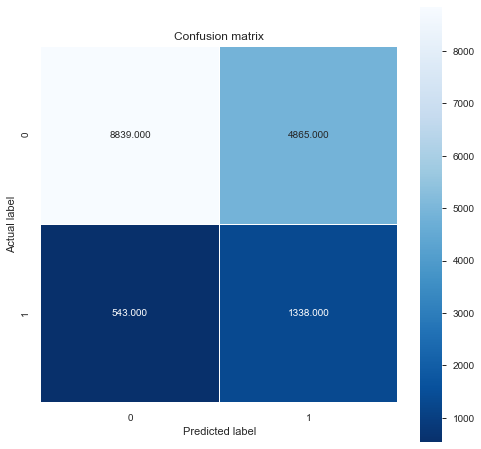

In [205]:
svm = SVC(gamma='auto', random_state=42)
svm.fit(X_resampled, y_resampled)

#Predict for test data sample
predictor(original_Xtest, original_ytest, svm)
mod_name.append('SVM')

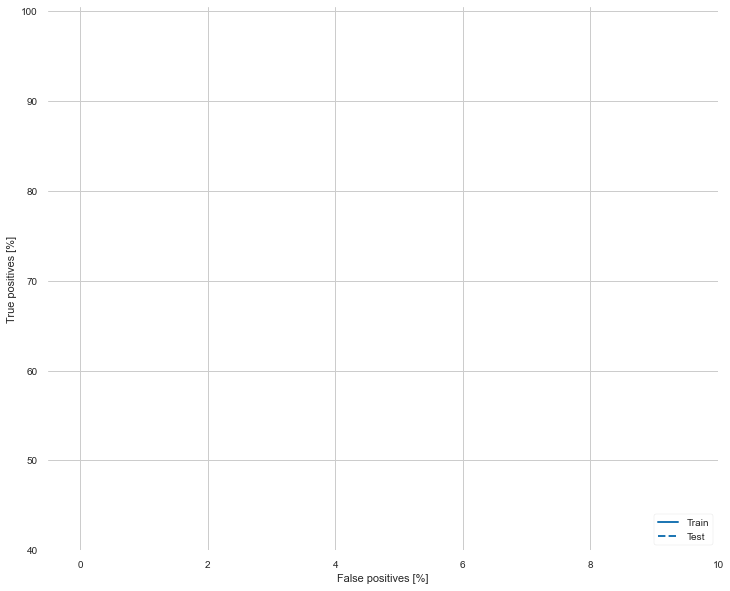

In [55]:
plot_roc("Train", y_resampled, svm.predict(X_resampled), color=colors[0])
plot_roc("Test", original_ytest,svm.predict(original_Xtest),linestyle='--')
plt.legend(loc='lower right')

### Random forest

Non-default Detected (True Negatives):  59401
Non-default Incorrectly Detected (False Positives):  32338
Default Missed (False Negatives):  3255
Default Detected (True Positives):  8903
Total Default:  12158
f1_score: 0.33345193730219663


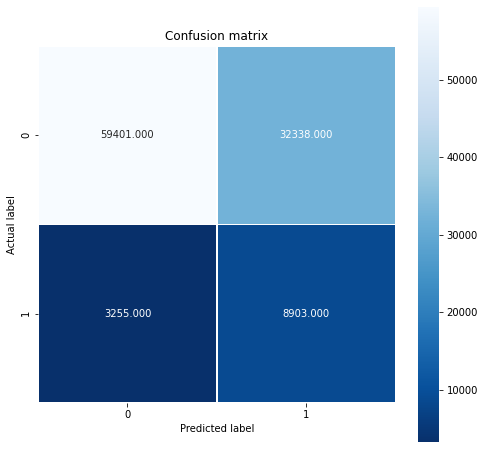

In [42]:
rf = RandomForestClassifier(n_estimators=100,max_depth=8,criterion='gini')
rf.fit(X_resampled, y_resampled)

#Predict for test data sample
predictor(original_Xtest, original_ytest, rf)
#predictor(X_resampled, y_resampled, rf)
mod_name.append('Random Forest')

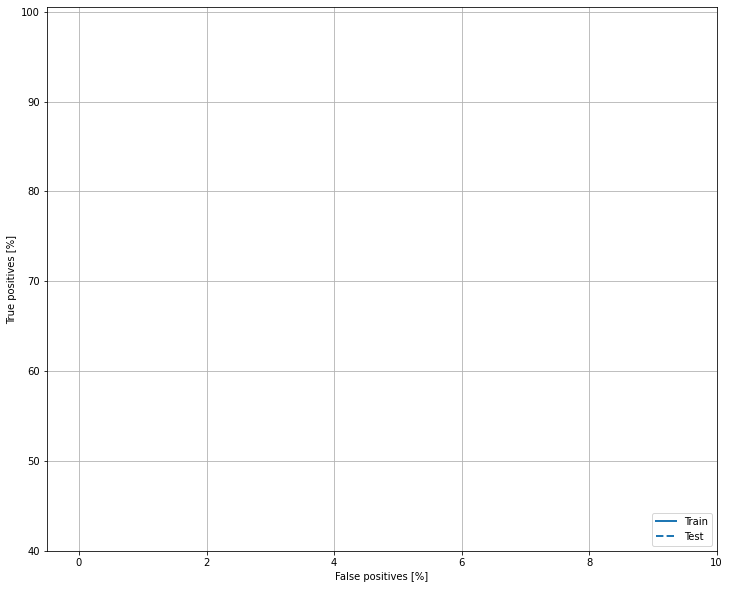

In [43]:
plot_roc("Train", y_resampled, rf.predict(X_resampled), color=colors[0])
plot_roc("Test", original_ytest,rf.predict(original_Xtest),linestyle='--')
plt.legend(loc='lower right')

Hyperparameter tuning
(Uncomment it if using it)

In [117]:

param_grid = { 
    'n_estimators': [20,60, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
gsearch1 = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
gsearch1.fit(X_resampled, y_resampled)
gsearch1.best_params_


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 100}

### Gradient Boost

Non-default Detected (True Negatives):  35655
Non-default Incorrectly Detected (False Positives):  19273
Default Missed (False Negatives):  1981
Default Detected (True Positives):  5429
Total Default:  7410
f1_score: 0.33812904833084206


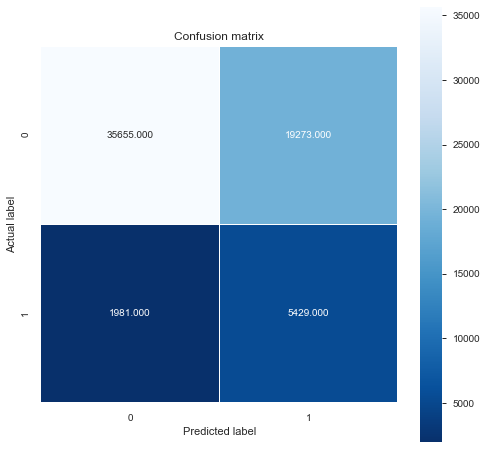

In [286]:
gbc = GradientBoostingClassifier() 

gbc.fit(X_resampled, y_resampled)

#Predict for test data sample
predictor(original_Xtest, original_ytest, gbc)
mod_name.append('Gradient Boost')

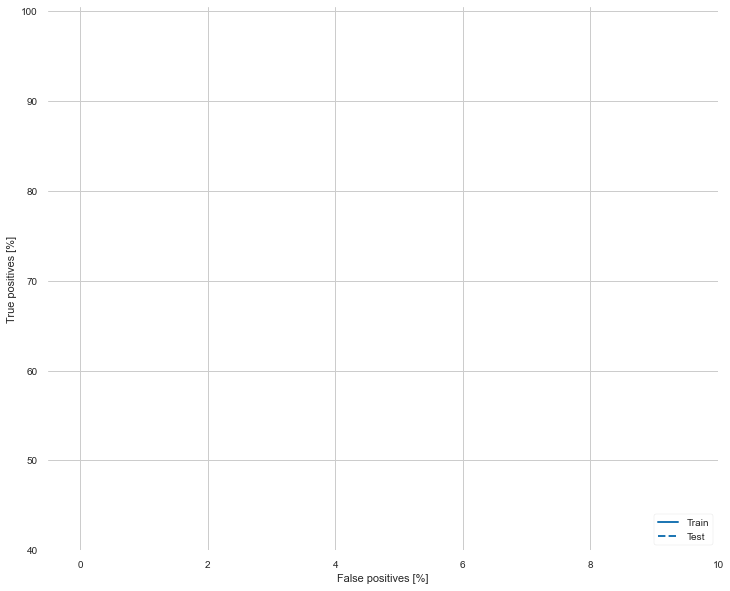

In [210]:
plot_roc("Train", y_resampled, gbc.predict(X_resampled), color=colors[0])
plot_roc("Test", original_ytest,gbc.predict(original_Xtest),linestyle='--')
plt.legend(loc='lower right')

Hyperparameter tuning
(Uncomment it if using it)

In [211]:
'''
param_grid = { 
    'learning_rate':[0.1,0.2,0.3], 
    'n_estimators': [20,60,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'subsample' : [0.5,1,2]
}
gsearch1 = GridSearchCV(estimator=gbc, param_grid=param_grid, cv= 5)
gsearch1.fit(X_resampled, y_resampled)
gsearch1.best_params_
'''

"\nparam_grid = { \n    'learning_rate':[0.1,0.2,0.3], \n    'n_estimators': [20,60,100],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth' : [4,5,6,7,8],\n    'subsample' : [0.5,1,2]\n}\ngsearch1 = GridSearchCV(estimator=gbc, param_grid=param_grid, cv= 5)\ngsearch1.fit(X_resampled, y_resampled)\ngsearch1.best_params_\n"

### XGBoost

Non-default Detected (True Negatives):  59998
Non-default Incorrectly Detected (False Positives):  31741
Default Missed (False Negatives):  3345
Default Detected (True Positives):  8813
Total Default:  12158
f1_score: 0.3343830626802246


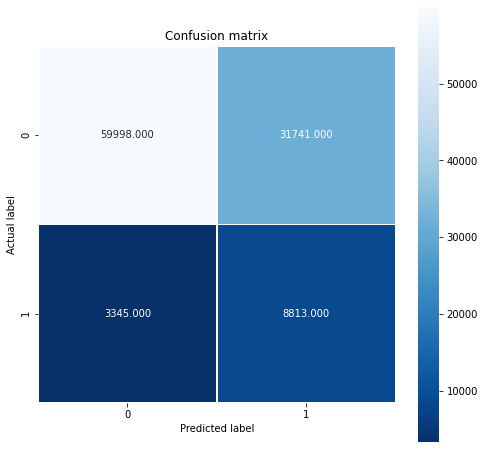

In [44]:
xgc = XGBClassifier() 

xgc.fit(X_resampled, y_resampled)

#Predict for test data sample
predictor(original_Xtest, original_ytest, xgc)
mod_name.append('XGBoost')

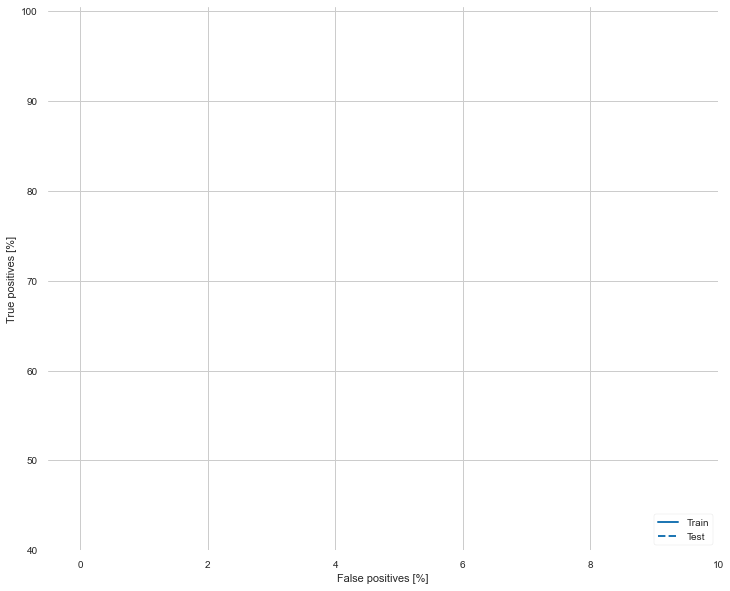

In [127]:
plot_roc("Train", y_resampled, xgc.predict(X_resampled), color=colors[0])
plot_roc("Test", original_ytest,xgc.predict(original_Xtest),linestyle='--')
plt.legend(loc='lower right')

Hyperparameter tuning
(Uncomment it if using it)

In [64]:
'''
params1 = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8,0.9, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6,7,8]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=20,

 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = params1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_resampled, y_resampled)
gsearch2.best_params_, gsearch2.best_score_
'''

"\nparams1 = {\n        'min_child_weight': [1, 5, 10],\n        'gamma': [0.5, 1, 1.5, 2, 5],\n        'subsample': [0.6, 0.8,0.9, 1.0],\n        'colsample_bytree': [0.6, 0.8, 1.0],\n        'max_depth': [4, 5, 6,7,8]\n}\ngsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=20,\n\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), \n param_grid = params1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)\ngsearch2.fit(X_resampled, y_resampled)\ngsearch2.best_params_, gsearch2.best_score_\n"

## Summary of results

In [217]:
metrics_sum = pd.DataFrame(columns = ['Accuracy','AUC','F1','Recall','Precision'],index=mod_name)
metrics_sum['Accuracy']=Acc
metrics_sum['F1']=F1
metrics_sum['Recall']=Reca
metrics_sum['Precision'] =Preci
metrics_sum['AUC']=Aucs

metrics_sum

,Accuracy,AUC,F1,Recall,Precision
Logistic Regression,0.681877,0.683652,0.335398,0.685968,0.221962
Random Forest,0.663003,0.690409,0.335251,0.726189,0.217930
XGBoost,0.684996,0.709676,0.355342,0.741898,0.233618


## Deep learning

### Define the model and metrics

In [91]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Normal Detected (True Negatives): ', cm[0][0])
  print('Normal Incorrectly Detected (False Positives): ', cm[0][1])
  print('Failure Missed (False Negatives): ', cm[1][0])
  print('Failure Detected (True Positives): ', cm[1][1])
  print('Total Failure: ', np.sum(cm[1]))

In [92]:
METRICS = [
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

n_inputs = X_resampled.shape[1]

def build_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
      keras.layers.Dense(16, activation='relu',input_shape=(n_inputs,)),
      #keras.layers.Dense(8, activation='relu'),
      #keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),])

  model.compile(
      optimizer=keras.optimizers.RMSprop(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [93]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [94]:
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint_name = 'bestmodel.h5' 
mcp = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50,restore_best_weights=True)

In [95]:
dnn_history=model.fit(X_resampled, y_resampled, validation_split=0.2, batch_size=50, epochs=200, shuffle=True, verbose=2, callbacks=[mcp])

Train on 1182 samples, validate on 296 samples
Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.34451, saving model to bestmodel.h5
1182/1182 - 5s - loss: 0.9407 - fp: 729.0000 - fn: 6.0000 - precision: 0.3748 - recall: 0.9865 - auc: 0.5583 - val_loss: 0.3445 - val_fp: 0.0000e+00 - val_fn: 5.0000 - val_precision: 1.0000 - val_recall: 0.9831 - val_auc: 0.0000e+00
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.34451
1182/1182 - 0s - loss: 0.8299 - fp: 690.0000 - fn: 11.0000 - precision: 0.3850 - recall: 0.9752 - auc: 0.6067 - val_loss: 0.4123 - val_fp: 0.0000e+00 - val_fn: 15.0000 - val_precision: 1.0000 - val_recall: 0.9493 - val_auc: 0.0000e+00
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.34451
1182/1182 - 0s - loss: 0.7471 - fp: 571.0000 - fn: 34.0000 - precision: 0.4173 - recall: 0.9233 - auc: 0.6441 - val_loss: 0.4839 - val_fp: 0.0000e+00 - val_fn: 32.0000 - val_precision: 1.0000 - val_recall: 0.8919 - val_auc: 0.0000e+00
Epoch 4/200

Epoch 00004: va

In [96]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

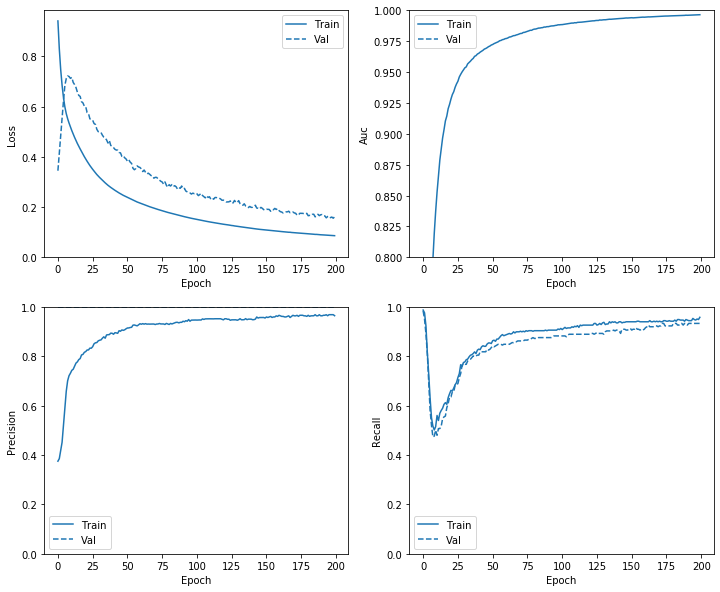

In [97]:
plot_metrics(dnn_history)

In [98]:
wights_file = 'bestmodel.h5'
model.load_weights(wights_file) # load it
# model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=keras.losses.BinaryCrossentropy(), metrics=['mean_absolute_error'])

Normal Detected (True Negatives):  312
Normal Incorrectly Detected (False Positives):  14
Failure Missed (False Negatives):  9
Failure Detected (True Positives):  15
Total Failure:  24


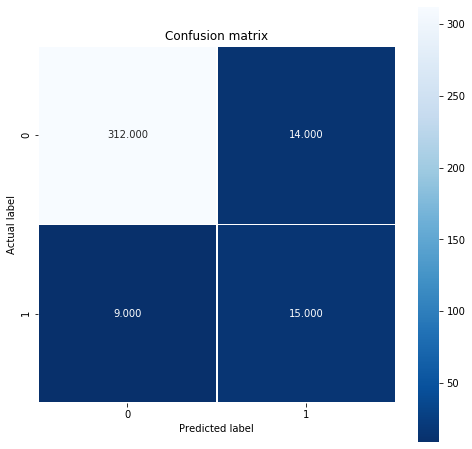

In [99]:
predictions=model.predict(original_Xtest)
plot_cm(original_ytest,predictions)

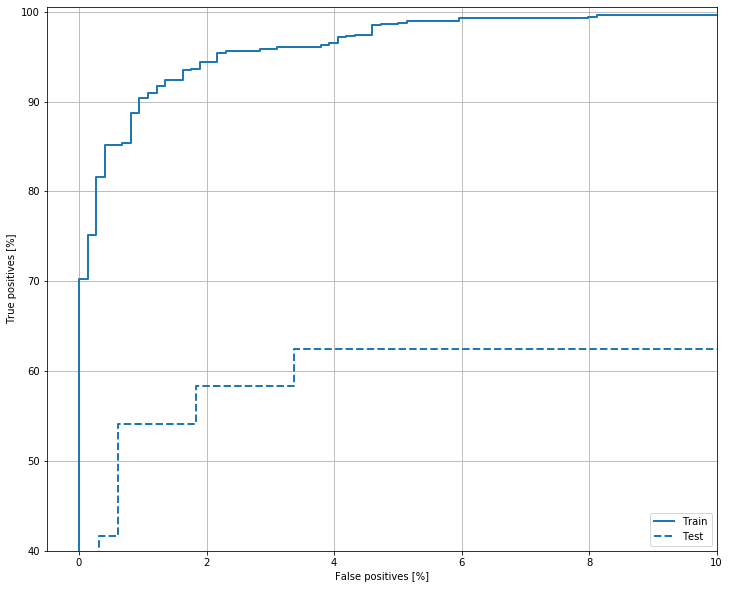

In [100]:
plot_roc("Train", y_resampled, model.predict(X_resampled), color=colors[0])
plot_roc("Test", original_ytest,predictions,linestyle='--')
plt.legend(loc='lower right')
